In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import nltk

In [26]:
spam =pd.read_csv("../data/spam.csv")

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 135-136: invalid continuation byte

In [ ]:
# You might have seen this error message before; 
# there are symbols in the data file that are invalid 
# unicode characters.  Apparently this file isn't
# in unicode. 

In [28]:
spam =pd.read_csv("../data/spam.csv", encoding="latin-1")

In [29]:
spam.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [30]:
spam.iloc[:,3].value_counts()

GE                                            2
 MK17 92H. 450Ppw 16"                         2
U NO THECD ISV.IMPORTANT TOME 4 2MORO\""      1
 why to miss them                             1
i wil tolerat.bcs ur my someone..... But      1
 \"OH No! COMPETITION\". Who knew             1
 ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\""    1
IåÕL CALL U\""                                1
 TX 4 FONIN HON                               1
whoever is the KING\"!... Gud nyt"            1
Name: Unnamed: 3, dtype: int64

In [31]:
spam.iloc[0]

v1                                                          ham
v2            Go until jurong point, crazy.. Available only ...
Unnamed: 2                                                  NaN
Unnamed: 3                                                  NaN
Unnamed: 4                                                  NaN
Name: 0, dtype: object

In [32]:
# Ok, I don't know what those last three columns are for, but I don't like them.
spamclean = []
for line in open("spam.csv", encoding="latin-1"):
        a = line.find(",")
        spamclean.append((line[0:a], line[a+1:]))

In [33]:
spam = pd.DataFrame(spamclean)

In [34]:
spam = spam.drop(labels=0, axis=0)  #only do this once

In [35]:
spam =spam.rename({0: "label", 1:"text"}, axis=1)

In [36]:
Y = spam.loc[:,"label"] == "spam"

In [37]:
Xtext = spam.loc[:,"text"]

In [38]:
Y[0:2], Xtext[0:2]

(1    False
 2    False
 Name: label, dtype: bool,
 1    "Go until jurong point, crazy.. Available only...
 2                   Ok lar... Joking wif u oni...,,,\n
 Name: text, dtype: object)

In [39]:
# Create two dataframes.. 
s1 = spam.query("label == 'ham'")
s2 = spam.query("label == 'spam'")

In [40]:
# Create two giant strings... 
s1text = s1.text.str.cat()
s2text = s2.text.str.cat()

In [41]:
# tokenize the strings (proably split on whitespace)
tok1 = nltk.word_tokenize(s1text)
tok2 = nltk.word_tokenize(s2text)

In [42]:
# And create frequency distribution objects.
d1 = nltk.FreqDist(tok1)
d2 = nltk.FreqDist(tok2)

In [43]:
d1  # This will act like a dictionary.

FreqDist({',': 15969, '.': 2952, "''": 2550, 'I': 1917, 'you': 1688, 'to': 1546, '?': 1375, '...': 1139, 'the': 1032, 'a': 977, ...})

In [44]:
# These methods look like number of token counts
d1.N(), d2.N()  

(100274, 23616)

In [45]:
# and these look like the number of distinct tokens.
len(d1.keys()), len(d2.keys()) 

(9524, 3756)

In [46]:
# Ten thousand words.  This is reasonable.


In [47]:
teststring = "Hey, what's up rich?"
teststring2 = "Do you want free airtime?"

In [48]:
# here is the frequency data I need.
# Word, ham_occur, ham_total, spam_occur, spam_total
print("Word\tham_occ\tham_tot\tspam_occ\tspam_tot")

for token in nltk.word_tokenize(teststring):
    print(token, '\t', end="" )
    print(d1[token] , '\t',  d1.N(),'\t', d2[token], 
          '\t', d2.N())

Word	ham_occ	ham_tot	spam_occ	spam_tot
Hey 	89 	 100274 	 5 	 23616
, 	15969 	 100274 	 2612 	 23616
what 	146 	 100274 	 14 	 23616
's 	422 	 100274 	 68 	 23616
up 	260 	 100274 	 19 	 23616
rich 	3 	 100274 	 0 	 23616
? 	1375 	 100274 	 175 	 23616


In [49]:
DEBUG=0
def score(utterance):
    cumscore = 0
    NHAM = d1.N()
    NSPAM = d2.N()
    MAXSCORE = np.log(20) / np.log(2)
    for token in nltk.word_tokenize(utterance):
        partialscore=0  # Catchall if a word has too few instances
        if d1[token] != 0 and d2[token] != 0 and (d1[token]+d2[token]) >= 5:
            partialscore = (np.log(d1[token]) - np.log(NHAM) -
                            np.log(d2[token])  + np.log(NSPAM))/np.log(2) 
            partialscore = np.minimum(MAXSCORE, np.maximum(-MAXSCORE, partialscore))
            if DEBUG: 
                print(partialscore, d1[token], d2[token])
        if d1[token] == 0 and d2[token] >= 5 :
            partialscore = -MAXSCORE
        if d2[token] == 0 and d1[token] >= 5 :
            partialscore = MAXSCORE
#        if d2[token] + d1[token] <5:
#            print("NOTENOUGH:", token ,d1[token],d2[token])
        cumscore = cumscore + partialscore
    return(cumscore)

In [50]:
score(teststring)

7.0137372990784455

In [51]:
score(teststring2)

1.6606746682599063

In [52]:
testset = ["Hey there, I am Maya with GP Research. We're surveying IL residents. Can you respond to a few questions?",
           "Headed down now.",
"The banana chocolate bread is delicious! All that’s left is one small heel, which I will dunk in my coffee tomorrow.",
"Hurry! For a limited time, add a FREE line to your account. Really, it's on us–no strings attached." ]


In [53]:
scores = []
for t in testset:
    print(score(t))
    scores.append(score(t))

15.350093920559605
1.8585810040798187
28.089364526748795
-2.7659561081069484


In [54]:
15.35
1.858
28.08
-2.766


-2.766

In [55]:
def p(odds):
    return odds / (1+odds)

In [56]:
for i,t  in enumerate(testset):
    print(scores[i], p (np.power(2,scores[i])),  t[0:20])

15.350093920559605 0.9999760585254013 Hey there, I am Maya
1.8585810040798187 0.7838542557627787 Headed down now.
28.089364526748795 0.999999996498463 The banana chocolate
-2.7659561081069484 0.12817248798257333 Hurry! For a limited


In [57]:
# Disappointingly, that "GP Research" SMS gets nailed as 10,000:1 in favor of ham.  

In [58]:
scores = []
for t in spam.text.values[0:10]:   # I don't want to print 5000 scores.
    print(score(t))
    scores.append(score(t))
scores = []
for t in spam.text.values:
    scores.append(score(t))

49.460913319335425
24.83370567887723
-64.75966435719417
35.52755835323976
45.29347741100416
4.3025365456745845
27.707288428200645
13.155881658772532
-62.972739287971365
-70.19336231511043


(array([ 11.,  10.,  16.,  25.,  42.,  47.,  41.,  40.,  51.,  77.,  53.,
         57.,  55.,  45.,  41.,  33.,  39.,  38., 194., 396., 667., 780.,
        572., 471., 330., 286., 242., 171., 154., 129.,  95.,  88.,  63.,
         54.,  39.,  17.,  15.,  18.,  12.,   6.,   6.,   3.,   3.,   6.,
          4.,   4.,   2.,   5.,   1.,   5.,   2.,   1.,   2.,   0.,   0.,
          2.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-88.44761342, -83.57761887, -78.70762432, -73.83762977,
        -68.96763522, -64.09764067, -59.22764612, -54.35765157,
        -49.48765702, -44.61766248, -39.74766793, -34.87767338,
        -30.00767883, -25.13768428, -20.26768973, -15.39769518,
        -10.52770063,  -5.65770608,  -0.78771153,   4.08228302

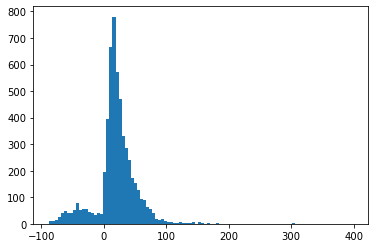

In [59]:
plt.hist(scores, bins=100)

In [60]:
# This would be a lot more interesting if it were class-conditional.
scores_ham = []
scores_spam = []
for t in spam.query("label=='ham'").text.values:
    scores_ham.append(score(t))
for t in spam.query("label=='spam'").text.values:
    scores_spam.append(score(t))

<ipython-input-61-0faab748659f>:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbbox_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("SPAMSPAMSPAMSPAM.png", dpi=300, bbbox_inches="tight")


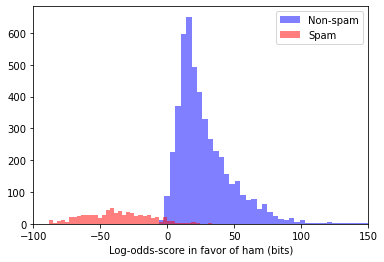

In [61]:
plt.hist(scores_ham, bins=100, color="blue", alpha=0.5, label="Non-spam")
plt.hist(scores_spam, bins=40, color="red", alpha=0.5, label="Spam")
plt.xlabel("Log-odds-score in favor of ham (bits)")
plt.xlim(-100, 150)
plt.legend()
plt.savefig("SPAMSPAMSPAMSPAM.png", dpi=300, bbbox_inches="tight")

In [62]:
def logistic(x):
    return 1 /( 1+ np.exp(-x))


<ipython-input-63-44d29878f791>:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbbox_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("PROBABILITYHAM.png", dpi=300, bbbox_inches="tight")


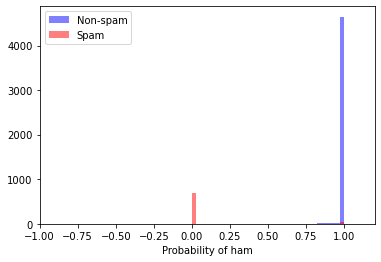

In [63]:
plt.hist(logistic(np.array(scores_ham)), bins=40, color="blue", alpha=0.5, label="Non-spam")
plt.hist(logistic(np.array(scores_spam)), bins=40, color="red", alpha=0.5, label="Spam")
plt.xlabel("Probability of ham")
plt.xlim(-1, 1.2)
plt.legend()
plt.savefig("PROBABILITYHAM.png", dpi=300, bbbox_inches="tight")

In [70]:
# I never got a crude accuracy from ham/spam in week2: 
# That's becuase I didn't articulate a threshold... 

hamcor = (np.array(scores_ham) > 0).sum()
hamtot =  len(scores_ham)
spamcor = (np.array(scores_spam) < 0).sum() 
spamtot = len(scores_spam)
print(hamcor, hamtot, hamcor/ hamtot)
print(spamcor, spamtot, spamcor/ spamtot)

4790 4825 0.9927461139896373
706 747 0.9451137884872824


In [71]:
# Crude accuracy
(hamcor+spamcor)/ (hamtot+spamtot)

0.9863603732950467

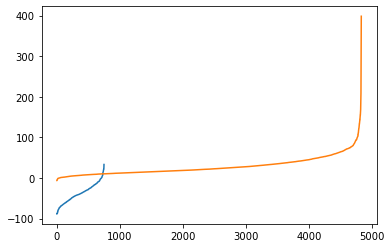

In [76]:
plt.plot(np.sort(scores_spam))
plt.plot(np.sort(scores_ham))

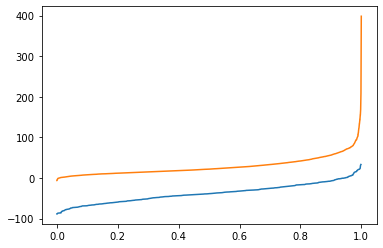

In [77]:
plt.plot(np.arange(len(scores_spam)) / len(scores_spam), np.sort(scores_spam))
plt.plot(np.arange(len(scores_ham)) / len(scores_ham), np.sort(scores_ham))

In [78]:
roc = pd.DataFrame({ "Hamscore": scores_ham})

In [82]:
roc["TPR"] = roc.Hamscore.apply(lambda x: np.array( roc.Hamscore > x).sum() / len(roc.Hamscore))

In [87]:
roc["TNR"] = roc.Hamscore.apply(lambda x: (np.array( scores_spam )< x).sum() /len(scores_spam) )

In [88]:
roc

,Hamscore,TPR,TNR
0,49.460913,0.142798,1.000000
1,24.833706,0.437098,0.997323
2,35.527558,0.270466,1.000000
3,45.293477,0.170777,1.000000
4,27.707288,0.378238,0.997323
...,...,...,...
4820,18.865521,0.575959,0.987952
4821,21.652001,0.505699,0.994645
4822,22.748080,0.483109,0.995984
4823,50.763361,0.135130,1.000000


Text(0, 0.5, 'TNR SPAM')

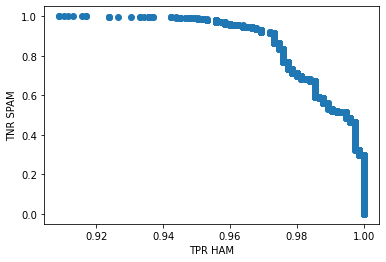

In [90]:
plt.scatter(roc.TNR, roc.TPR)
plt.xlabel("TPR HAM")
plt.ylabel("TNR SPAM")